In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pprint

import matplotlib as mpl
from PIL import Image
from io import BytesIO
mpl.rc('figure', dpi=400, figsize=(12,8))


%matplotlib inline

In [2]:
def TIFF_exporter(fig, fname, fig_dir = '.'):
    """
    Parameters
    ----------
    fig: matplotlib figure
    """
    
    # save figure
    # (1) save the image in memory in PNG format
    png1 = BytesIO()
    fig.savefig(png1, format='png', bbox_inches='tight', dpi=350)

    # (2) load this image into PIL
    png2 = Image.open(png1)

    # (3) save as TIFF
    png2.save(os.path.join(fig_dir,'{}.tiff'.format(fname)))
    png1.close()
    return True

# BP_Hypothermia Model 1 - single `Q_10` value #

In [3]:
def data_import_and_clean(dataset, version):
    df = pd.read_csv('../../../data/SA_results/bph_{}/with_cellDeath/nrmse/{}/sensitivities.txt'.format(version, dataset), sep='\t')
    for p in (['u', 'P_a', 'SaO2sup', 'Pa_CO2', 'temp']):    
        df = df.query("Parameter!='{}'".format(p))
    df_zero = pd.read_csv('../../../data/SA_results/bph_{}/with_cellDeath/nrmse_zero/{}/sensitivities.txt'.format(version, dataset), sep='\t')
    for p in (['u', 'P_a', 'SaO2sup', 'Pa_CO2', 'temp']):    
        df_zero = df_zero.query("Parameter!='{}'".format(p))
    return df, df_zero

In [4]:
datasets = ['LWP475', 'LWP479', 'LWP481', 'LWP484']
df_dict = {}
df_zero_dict = {}
for dataset in datasets:
    df_dict[dataset], df_zero_dict[dataset] = data_import_and_clean(dataset, 1)

In [5]:
title_dict = {"TOTAL": "all outputs", "CCO": "CCO", "HbO2": "HbO$_2$", "HHb": "HHb"}

def sensitivity(df, output, title_dict=None):      
    params = ["Parameter", output+"_mu_star", output+"_mu_star_conf", output+"_sigma"]
    sens = df[params]
    sens = sens.rename(columns={output+"_mu_star": "mu_star", output+"_sigma": "sigma", output+"_mu_star_conf": "mu_star_conf"})
    sens.sort_values(by="mu_star", ascending=False, inplace=True)
    sens_head = sens.head(20)
    with sns.plotting_context("talk"):
        fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,6))

        ax.set(xscale="log", yscale="log")
        plt.grid(True, linestyle=':')
        ax = sns.scatterplot(x="mu_star", y="sigma", data=sens_head, ax=ax, hue="Parameter")
        ax.set_ylabel("$\sigma$")
        ax.set_xlabel("$\mu_{*}$")
        if title_dict:
            ax.set_title("Sensitivity for {}".format(title_dict[output]))

        lgd = ax.legend(loc="upper right", bbox_to_anchor=(1.55, 1))

    
    return fig, ax, lgd, sens_head

In [6]:
sim_data = {}
sim_data_zero = {}
outputs = ["TOTAL", "HHb", "HbO2", "CCO"]
for output in outputs:
    sim_data[output]={}
    sim_data_zero[output]={}
    for dataset in datasets:
        print("Working on {} in {} - non-zero". format(output, dataset))
        fig, ax, lgd, d = sensitivity(df_dict[dataset], output, title_dict=title_dict)
        sim_data[output][dataset]= d
        print("Working on {} in {} - zero". format(output, dataset))
        fig, ax, lgd, d_zero = sensitivity(df_zero_dict[dataset], output, title_dict=title_dict)
        sim_data_zero[output][dataset]= d_zero
plt.close('all')

Working on TOTAL in LWP475 - non-zero
Working on TOTAL in LWP475 - zero
Working on TOTAL in LWP479 - non-zero
Working on TOTAL in LWP479 - zero
Working on TOTAL in LWP481 - non-zero
Working on TOTAL in LWP481 - zero
Working on TOTAL in LWP484 - non-zero
Working on TOTAL in LWP484 - zero
Working on HHb in LWP475 - non-zero
Working on HHb in LWP475 - zero
Working on HHb in LWP479 - non-zero
Working on HHb in LWP479 - zero
Working on HHb in LWP481 - non-zero
Working on HHb in LWP481 - zero
Working on HHb in LWP484 - non-zero
Working on HHb in LWP484 - zero
Working on HbO2 in LWP475 - non-zero
Working on HbO2 in LWP475 - zero
Working on HbO2 in LWP479 - non-zero
Working on HbO2 in LWP479 - zero
Working on HbO2 in LWP481 - non-zero
Working on HbO2 in LWP481 - zero
Working on HbO2 in LWP484 - non-zero
Working on HbO2 in LWP484 - zero


/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Working on CCO in LWP475 - non-zero
Working on CCO in LWP475 - zero
Working on CCO in LWP479 - non-zero
Working on CCO in LWP479 - zero
Working on CCO in LWP481 - non-zero
Working on CCO in LWP481 - zero
Working on CCO in LWP484 - non-zero
Working on CCO in LWP484 - zero


# Combined data #


In [7]:
%%capture
l = []
l_zero = []
for output in outputs:
    for k, d in sim_data[output].items():
        print("{} - {}".format(output, k))
        print(d.columns)
        d['Dataset'] = k
        d['Output'] = output
        l.append(d)
    for k, d in sim_data_zero[output].items():
        print("{} - {}".format(output, k))
        print(d.columns)
        d['Dataset'] = k
        d['Output'] = output
        l_zero.append(d)
                
combined = pd.concat(l, sort=False)
combined_zero = pd.concat(l_zero, sort=False)


# Sensitivity Results as Scatter Plot #

Here we visualise $\mu_{*}$ again $\sigma$ for each dataset and output for the top 20 most sensitive parameters in each grouping. 
Legends for each grap hare turned off for neatness here - we're simply looking at the relationship  between $\mu_{*}$ and $\sigma$ rather than what it means for a particular variable. 

All graphs show a roughly linear relationship with the __TOTAL__ output being clustered towards higher $\mu_{*}$ values than the individual outputs.

Text(0.5, 0.98, 'NaN replaced with 10,000,000')

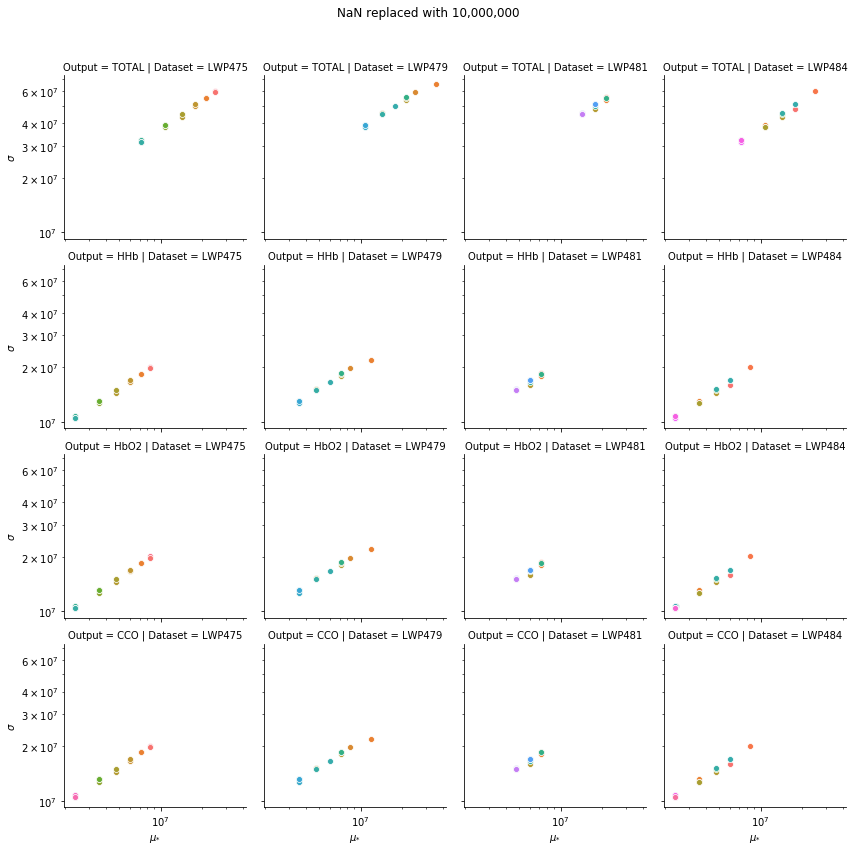

In [8]:
g = sns.FacetGrid(data=combined, col='Dataset', row="Output", hue="Parameter", subplot_kws={"xscale":"log", "yscale":"log"})
g = g.map(sns.scatterplot, "mu_star", "sigma")
g.set_xlabels("$\mu_{*}$")
g.set_ylabels("$\sigma$")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('NaN replaced with 10,000,000')



Text(0.5, 0.98, 'NaN replaced with zero')

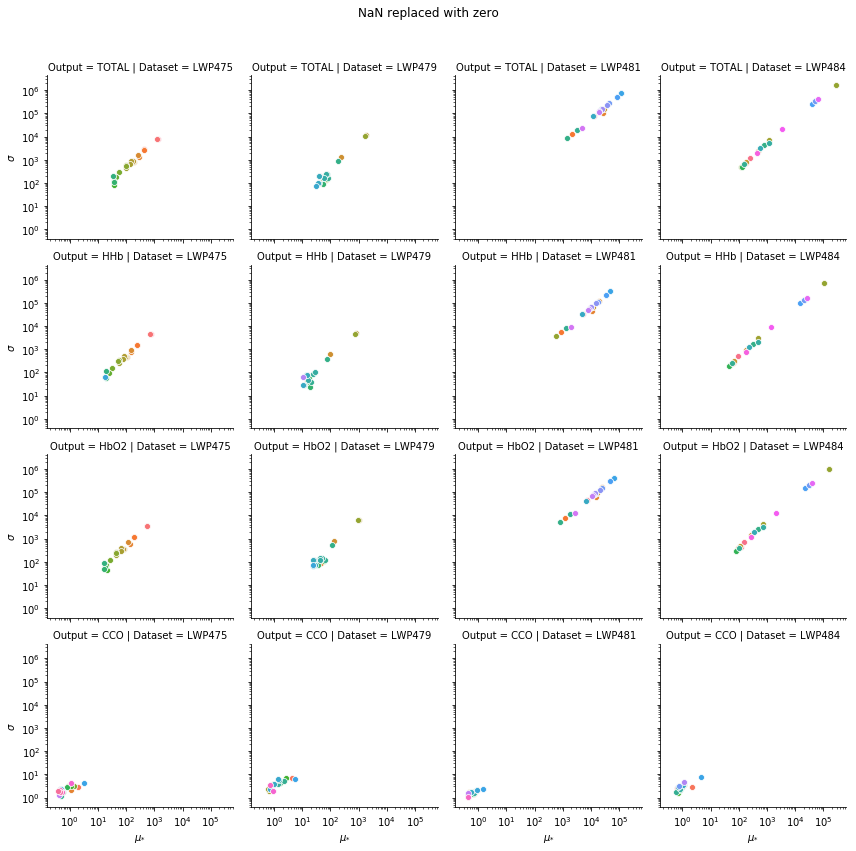

In [9]:
g = sns.FacetGrid(data=combined_zero, col='Dataset', row="Output", hue="Parameter", subplot_kws={"xscale":"log", "yscale":"log"})
g = g.map(sns.scatterplot, "mu_star", "sigma")
g.set_xlabels("$\mu_{*}$")
g.set_ylabels("$\sigma$")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('NaN replaced with zero')

# $\mu_{*}$ values as a bar chart # 

We can look at what parameters are within the top 20 for each grouping and also at their respective values. All graphs share an x axis and so can be compared directly down columns and across rows. The x-axis is on a log scale.

We see that the  __TOTAL__ output shows a small amount of drop off as the parameter becomes less sensitive than most other outputs. We also see simliar patterns for each dataset across the rows, but the actual parameters themselves do vary in each "top 10".

In order to properly visualise what parameters are within each grouping and what are most sensitive, we need to visualise the set of all parameters across all groupings.

/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 0.98, 'NaN replaced with 10,000,000')

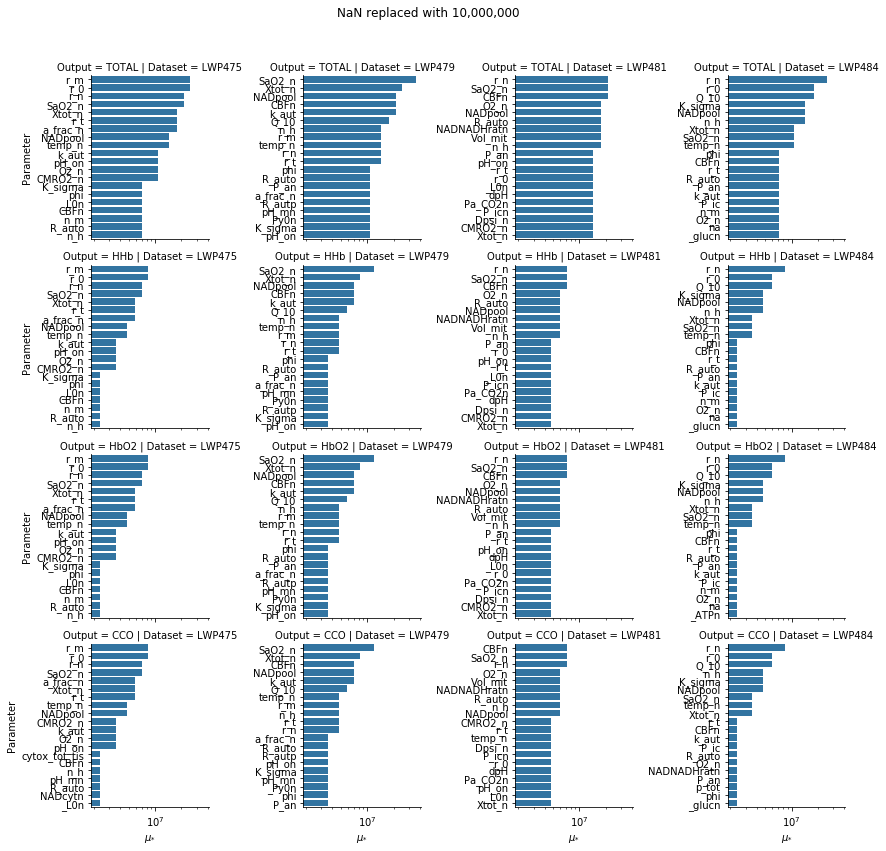

In [10]:
g = sns.FacetGrid(data=combined, col='Dataset', row="Output", sharey=False, subplot_kws={"xscale":"log"})
g= g.map(sns.barplot, "mu_star", "Parameter")
g.set_xlabels("$\mu_{*}$")


plt.subplots_adjust(top=0.9)
g.fig.suptitle('NaN replaced with 10,000,000')

/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 0.98, 'NaN replaced with zero')

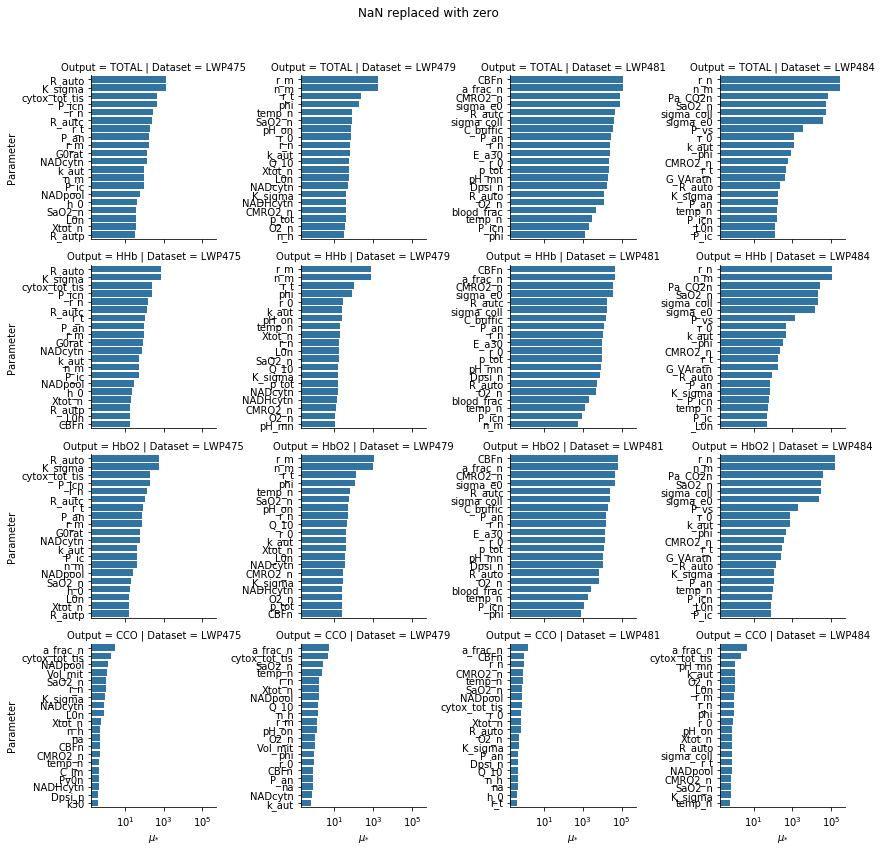

In [11]:
g = sns.FacetGrid(data=combined_zero, col='Dataset', row="Output", sharey=False, subplot_kws={"xscale":"log"})
g= g.map(sns.barplot, "mu_star", "Parameter")
g.set_xlabels("$\mu_{*}$")


plt.subplots_adjust(top=0.9)
g.fig.suptitle('NaN replaced with zero')

In [12]:
%%capture
param_count = pd.DataFrame(combined.groupby(['Output', 'Parameter']).nunique()['mu_star'])

param_count_zero = pd.DataFrame(combined_zero.groupby(['Output', 'Parameter']).nunique()['mu_star'])

In [13]:
import itertools
tuple_index = itertools.product(outputs, datasets)

In [14]:
index = pd.MultiIndex.from_tuples(list(tuple_index), names=['Output', 'Dataset'])

In [15]:
combined_indexed = combined.copy().set_index(['Output', 'Dataset'])
combined_zero_indexed = combined_zero.copy().set_index(['Output', 'Dataset'])

In [16]:
combined_pivoted = pd.pivot_table(combined.copy(), index='Parameter', columns=['Output', 'Dataset'], values='mu_star')
combined_zero_pivoted = pd.pivot_table(combined_zero.copy(), index='Parameter', columns=['Output', 'Dataset'], values='mu_star')


In [17]:
combined_pivoted=combined_pivoted.replace(0, np.nan)
combined_zero_pivoted=combined_zero_pivoted.replace(0, np.nan)

# Heat map visualisation #

In order to fully explore the parameters that have been shown as sensitive by sensitivity analysis, we can viaualise the set of all parameters in the above groupings as a heatmap. The more purple that a parameter is the more sensitive it is.

By visualising in this way we can clearly see when a parameter ispresent in multiple datasets and outputs and where it is most sensitive.

Columns are aligned such that the 4 datasets are grouped into each output, with the final output being the __TOTAL__.

Text(0.5, 0.98, 'NaN replaced with 10,000,000')

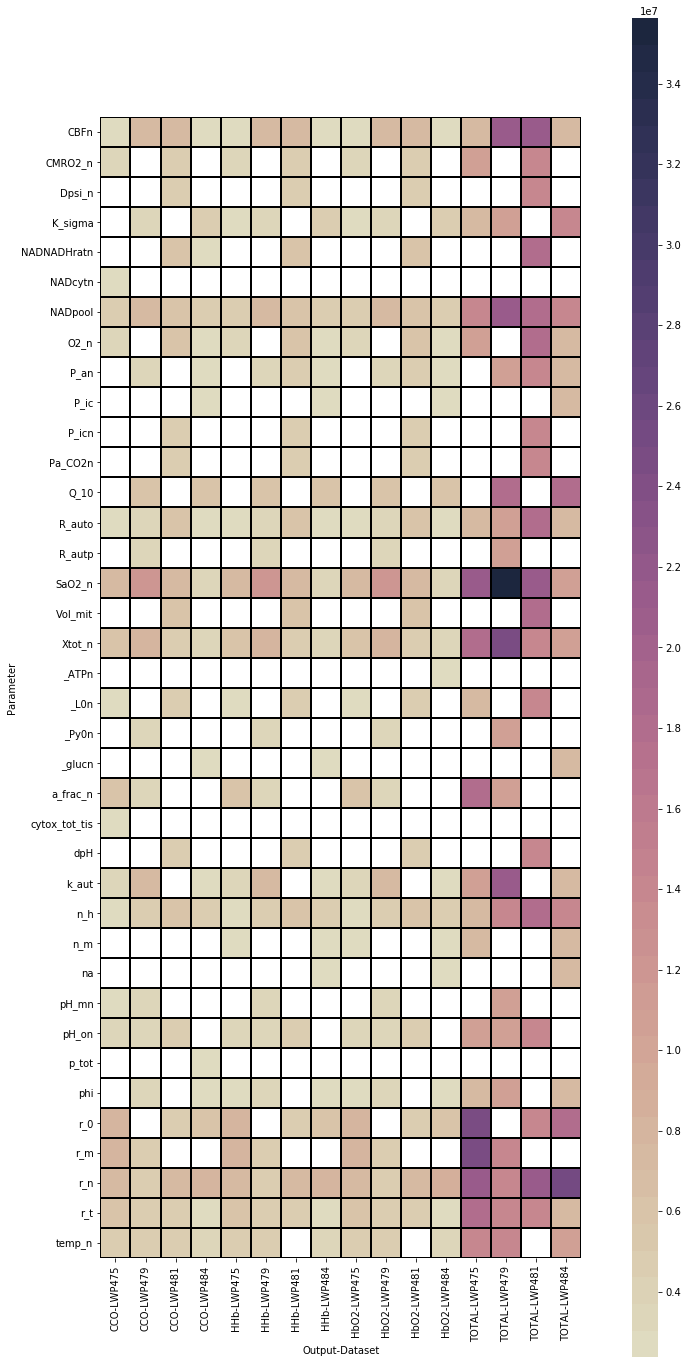

In [18]:
from matplotlib import ticker
default_ticker = mpl.ticker.MaxNLocator(20)
grid_kws = {"width_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(ncols=2, figsize=(10,24), gridspec_kw=grid_kws)
ax = sns.heatmap(combined_pivoted,
                 cmap = sns.cubehelix_palette(50, start=-.5, rot=.75),
                 square=True,
                 linecolor='black',
                 linewidth=1,
                 ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "vertical", "ticks": default_ticker})

plt.subplots_adjust(top=0.9)
g.fig.suptitle('NaN replaced with 10,000,000')
#sns.heatmap(combined_pivoted, cmap = sns.light_palette("green"), square=True, linecolor='black', linewidth=0.2)

Text(0.5, 0.98, 'NaN replaced with zero')

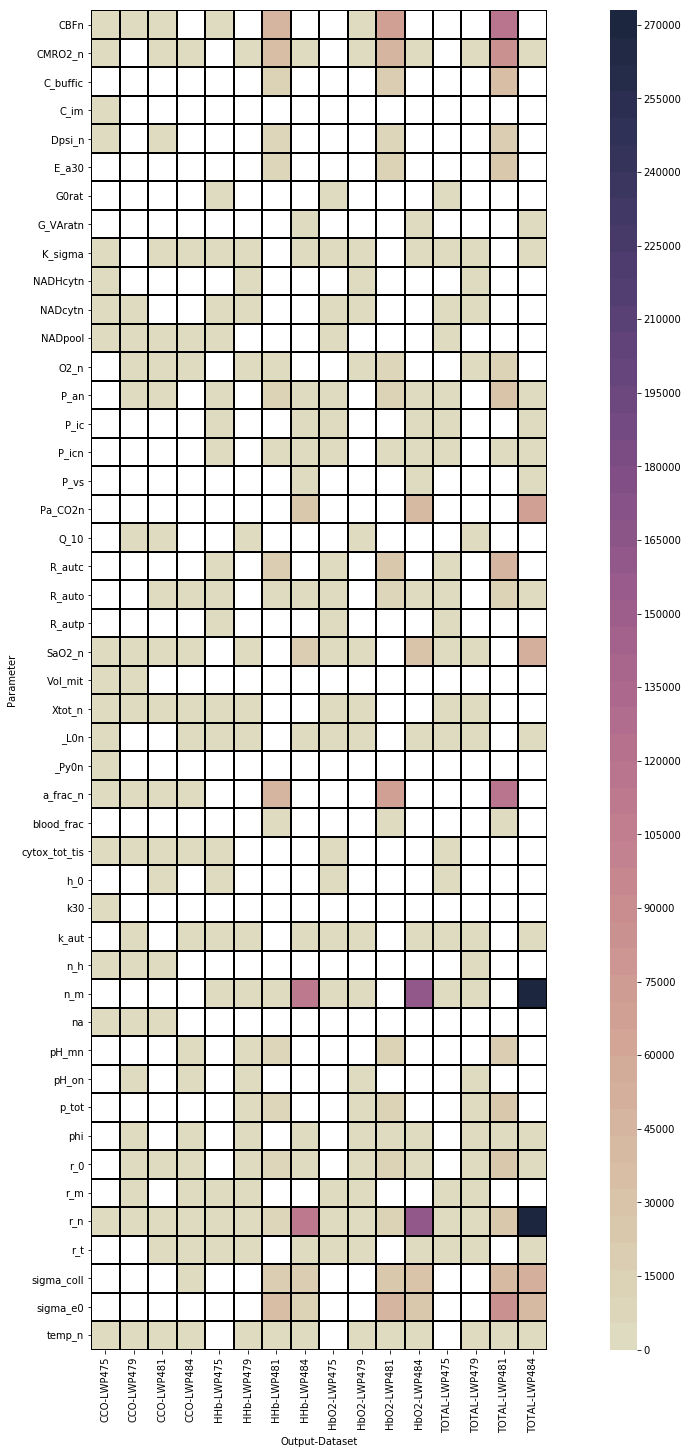

In [19]:
from matplotlib import ticker
default_ticker = mpl.ticker.MaxNLocator(20)
grid_kws = {"width_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(ncols=2, figsize=(10,24), gridspec_kw=grid_kws)
ax = sns.heatmap(combined_zero_pivoted,
                 cmap = sns.cubehelix_palette(50, start=-.5, rot=.75),
                 square=True,
                 linecolor='black',
                 linewidth=1,
                 ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "vertical", "ticks": default_ticker})
plt.subplots_adjust(top=0.9)
g.fig.suptitle('NaN replaced with zero')


#sns.heatmap(combined_pivoted, cmap = sns.light_palette("green"), square=True, linecolor='black', linewidth=0.2)

In [20]:
combined_pivoted.shape

(38, 16)

In [21]:
combined_indexed.loc['TOTAL']['Parameter'].unique()

array(['r_m', 'r_0', 'r_n', 'SaO2_n', 'Xtot_n', 'r_t', 'a_frac_n',
       'NADpool', 'temp_n', 'k_aut', 'pH_on', 'O2_n', 'CMRO2_n',
       'K_sigma', 'phi', '_L0n', 'CBFn', 'n_m', 'R_auto', 'n_h', 'Q_10',
       'P_an', 'R_autp', 'pH_mn', '_Py0n', 'NADNADHratn', 'Vol_mit',
       'dpH', 'Pa_CO2n', 'P_icn', 'Dpsi_n', 'P_ic', 'na', '_glucn'],
      dtype=object)

In [22]:
combined_zero_indexed.loc['TOTAL']['Parameter'].unique()

array(['R_auto', 'K_sigma', 'cytox_tot_tis', 'P_icn', 'r_n', 'R_autc',
       'r_t', 'P_an', 'r_m', 'G0rat', 'NADcytn', 'k_aut', 'n_m', 'P_ic',
       'NADpool', 'h_0', 'SaO2_n', '_L0n', 'Xtot_n', 'R_autp', 'phi',
       'temp_n', 'pH_on', 'r_0', 'Q_10', 'NADHcytn', 'CMRO2_n', 'p_tot',
       'O2_n', 'n_h', 'CBFn', 'a_frac_n', 'sigma_e0', 'sigma_coll',
       'C_buffic', 'E_a30', 'pH_mn', 'Dpsi_n', 'blood_frac', 'Pa_CO2n',
       'P_vs', 'G_VAratn'], dtype=object)

# Choice of Parameters #
We decide what parameters to use for fitting based on domain knowledge informed by the above results.
A rough guide is to choose parameters that appear in at least 50% of sensitivity results. Additionally, parameters that appear to be important for one output but not other should also be considered. For example, the metabolic submodel is only represented by the CCO output and so if using only the __TOTAL__ output important parameter may not appear. This appears to be the case for *cytox_tot_tis* which appears in all datasets for CCO output, but not for any other output.

We can use the `param_count`dataframe created earlier to look at how many times each parameter appears. We can then supplement this with parameters based on domain knowledge.

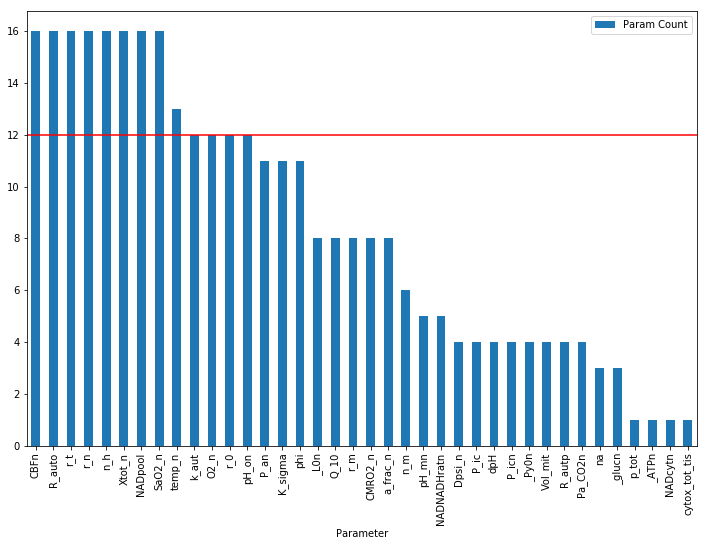

In [23]:
cutoff = 4*len(outputs)*0.75
total_count = pd.DataFrame(combined.groupby(['Parameter']).nunique()['mu_star'])
total_count.rename({'mu_star': 'Param Count'}, axis='columns', inplace=True)
total_count.sort_values(by='Param Count', ascending=False, inplace=True)

f = total_count.plot.bar(figsize=(12,8))
f.axhline(y=cutoff, color='r')

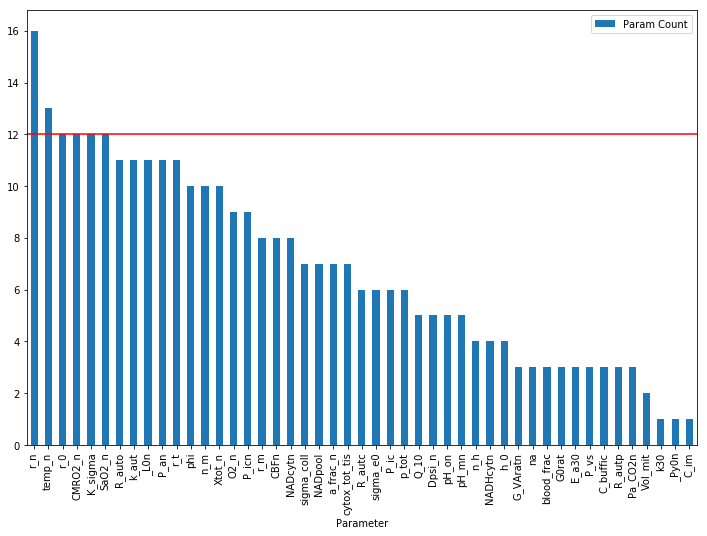

In [24]:
cutoff = 4*len(outputs)*0.75
total_count_zero = pd.DataFrame(combined_zero.groupby(['Parameter']).nunique()['mu_star'])
total_count_zero.rename({'mu_star': 'Param Count'}, axis='columns', inplace=True)
total_count_zero.sort_values(by='Param Count', ascending=False, inplace=True)

f = total_count_zero.plot.bar(figsize=(12,8))
f.axhline(y=cutoff, color='r')

In [25]:
included_parameters_df = total_count[total_count['Param Count']>cutoff]
# included_parameters_df.rename({'mu_star': 'Param Count'}, axis='columns', inplace=True)
# included_parameters_df.sort_values(by='Param Count', ascending=False)

included_parameters = list(included_parameters_df.index)

included_parameters_df_zero = total_count_zero[total_count_zero['Param Count']>cutoff]

included_parameters_zero = list(included_parameters_df_zero.index)

In [26]:
included_parameters

['CBFn',
 'R_auto',
 'r_t',
 'r_n',
 'n_h',
 'Xtot_n',
 'NADpool',
 'SaO2_n',
 'temp_n']

In [27]:
included_parameters_zero

['r_n', 'temp_n']

In [28]:
individual_count = {}
for output in outputs[1:]:
    individual_count[output] = param_count.loc[output][param_count.loc[output,'mu_star']>=3]
    
individual_count_zero = {}
for output in outputs[1:]:
    individual_count_zero[output] = param_count_zero.loc[output][param_count_zero.loc[output,'mu_star']>=3]

### CCO ###
    

In [29]:
included_parameters.extend(list(individual_count['CCO'].index))
individual_count['CCO']

,mu_star
Parameter,
CBFn,4
NADpool,4
O2_n,3
R_auto,4
SaO2_n,4
Xtot_n,4
k_aut,3
n_h,4
pH_on,3


In [30]:
included_parameters_zero.extend(list(individual_count_zero['CCO'].index))
individual_count_zero['CCO']

,mu_star
Parameter,
CBFn,3
CMRO2_n,3
K_sigma,3
NADpool,4
O2_n,3
SaO2_n,4
Xtot_n,4
a_frac_n,4
cytox_tot_tis,4


### HbO$_2$ ###

In [31]:
included_parameters.extend(list(individual_count['HbO2'].index))
individual_count['HbO2']

,mu_star
Parameter,
CBFn,4
K_sigma,3
NADpool,4
O2_n,3
P_an,3
R_auto,4
SaO2_n,4
Xtot_n,4
k_aut,3


In [32]:
included_parameters_zero.extend(list(individual_count_zero['HbO2'].index))
individual_count_zero['HbO2']

,mu_star
Parameter,
CMRO2_n,3
K_sigma,3
P_an,3
P_icn,3
R_auto,3
SaO2_n,3
_L0n,3
k_aut,3
n_m,3


### HHb ###


In [33]:
included_parameters.extend(list(individual_count['HHb'].index))
individual_count['HHb']

,mu_star
Parameter,
CBFn,4
K_sigma,3
NADpool,4
O2_n,3
P_an,3
R_auto,4
SaO2_n,4
Xtot_n,4
k_aut,3


In [34]:
included_parameters_zero.extend(list(individual_count_zero['HHb'].index))
individual_count_zero['HHb']

,mu_star
Parameter,
CMRO2_n,3
K_sigma,3
P_an,3
P_icn,3
R_auto,3
_L0n,3
k_aut,3
n_m,4
r_0,3


 Now that we have a list of all parameters that fit our criteria we can use `set()` to remove duplicates and get the final combination.

# Final Parameter selection #
## Non-zero replacement ##

In [35]:
final_params_list = set(included_parameters)
pprint.pprint(final_params_list)

{'CBFn',
 'K_sigma',
 'NADpool',
 'O2_n',
 'P_an',
 'R_auto',
 'SaO2_n',
 'Xtot_n',
 'k_aut',
 'n_h',
 'pH_on',
 'phi',
 'r_0',
 'r_n',
 'r_t',
 'temp_n'}


In [36]:
len(final_params_list)

16

Finally, even though it wasn't identified as important by the SA process, the hypothermia model includes $Q_{10}$ as a way of controlling the impact of temperature and this parameter should be included in the fitting process for the purposes of identifying its impact as well as for fitting.

In [37]:
final_params_list.add('Q_10')

In [38]:
final_params_list

{'CBFn',
 'K_sigma',
 'NADpool',
 'O2_n',
 'P_an',
 'Q_10',
 'R_auto',
 'SaO2_n',
 'Xtot_n',
 'k_aut',
 'n_h',
 'pH_on',
 'phi',
 'r_0',
 'r_n',
 'r_t',
 'temp_n'}

In [39]:
print("Number of variables is {}.".format(len(final_params_list)))

Number of variables is 17.


The number of variables finally selected is still relatively high. Whilst it is important to make sure we provide adequate coverage of parameter space in order to sufficiebtly fit the model, we can potentially reduce the number of parameters that require fitting by removing those which are unlikely to be massively different from the default value. For example, changing `temp_n` clearly has a large impact on the model, but it is extremely unlikely that the normal body temperature of this piglet was significantly different from the default value. Similarly, the normal *SaO2* value given by `SaO2_n` is unlikely to be very different from the default value given that we have recordings of this value at the start of the measurement period and it is similar if not exactly the same as the default value for most piglets.

Other parameters that may fall into this category include normal blood pressure `P_an` and normal partial prssure of CO2 `PaCO2_n`. These parameters are important, but when focussing on the impact an injury has had in terms of function, parameters that control what we expect a 'normal' input etc. are unlikely to provide useful information when fitting. It is potentially more useful to leave many of the 'normal value' parameters at their default values. The normal value of blood pressure, for example, should probably be kept the same across all piglets. Then, if the impact of blood pressure is different from the expected 'healthy' behaviour, it should be more dynamic parameters that control these changes, rather than modifying what we consider to be a normal blood pressure. 

In [40]:
for p in ('SaO2_n', 'temp_n', 'Pa_CO2n', 'P_an', 'Vol_totn'):
    try:
        final_params_list.remove(p)
    except KeyError:
        continue
    


In [41]:
pprint.pprint(final_params_list)

{'CBFn',
 'K_sigma',
 'NADpool',
 'O2_n',
 'Q_10',
 'R_auto',
 'Xtot_n',
 'k_aut',
 'n_h',
 'pH_on',
 'phi',
 'r_0',
 'r_n',
 'r_t'}


In [42]:
print("Final parameter list length is: {}".format(len(final_params_list)))

Final parameter list length is: 14


## Zero replacement ##

In [43]:
final_params_list_zero = set(included_parameters_zero)
pprint.pprint(final_params_list_zero)

{'CBFn',
 'CMRO2_n',
 'K_sigma',
 'NADpool',
 'O2_n',
 'P_an',
 'P_icn',
 'R_auto',
 'SaO2_n',
 'Xtot_n',
 '_L0n',
 'a_frac_n',
 'cytox_tot_tis',
 'k_aut',
 'n_h',
 'n_m',
 'na',
 'phi',
 'r_0',
 'r_n',
 'r_t',
 'temp_n'}


In [44]:
len(final_params_list_zero)

22

Finally, even though it wasn't identified as important by the SA process, the hypothermia model includes $Q_{10}$ as a way of controlling the impact of temperature and this parameter should be included in the fitting process for the purposes of identifying its impact as well as for fitting. 

In [45]:
final_params_list_zero.add("Q_10")

In [46]:
final_params_list_zero

{'CBFn',
 'CMRO2_n',
 'K_sigma',
 'NADpool',
 'O2_n',
 'P_an',
 'P_icn',
 'Q_10',
 'R_auto',
 'SaO2_n',
 'Xtot_n',
 '_L0n',
 'a_frac_n',
 'cytox_tot_tis',
 'k_aut',
 'n_h',
 'n_m',
 'na',
 'phi',
 'r_0',
 'r_n',
 'r_t',
 'temp_n'}

In [47]:
for p in ('SaO2_n', 'temp_n', 'Pa_CO2n', 'P_an', 'Vol_totn'):
    try:
        final_params_list_zero.remove(p)
    except KeyError:
        continue

As before we need to massively reduce the number of parameters - we have significantly more parameters here than in the non-zero replacement'

What we can do is generate a final list that is the intersection of these two version - we should then find parameters that occur in both meaning that they are important without having a good chance of producing NAN results.

In [48]:
pprint.pprint(final_params_list_zero)

{'CBFn',
 'CMRO2_n',
 'K_sigma',
 'NADpool',
 'O2_n',
 'P_icn',
 'Q_10',
 'R_auto',
 'Xtot_n',
 '_L0n',
 'a_frac_n',
 'cytox_tot_tis',
 'k_aut',
 'n_h',
 'n_m',
 'na',
 'phi',
 'r_0',
 'r_n',
 'r_t'}


In [49]:
print("Final parameter list length is: {}".format(len(final_params_list_zero)))

Final parameter list length is: 20


In [50]:
overall_selection = final_params_list & final_params_list_zero

# Parameter config creation #

In [51]:
def openopt_param_creator(d, f):
    """Create an input dictionary of uniform parameter priors for openopt.

    Parameters
    ----------
    d : dict
        Dictionary of paramaters and their default values.

    f : float
        Float greater than 0 to define limits of distribution. A value of 0.25
        is equivalent to a 25% change either way.

    Returns
    -------
    None
        Prints parameter specification to terminal in format compatible with
        :module:`optim.py`

    """
    for k, v in d.items():
        print('param: {}, {Dist_Type}, {Min:.4f}, {Max:.4f}, {Default:.4f}'.format(k, **v))
    return None

In [52]:
# param_df_1 = pd.read_csv('~/repos/Github/BayesCMD/batch/scratch/pdists_hypothermia.csv',
#                        header=None,
#                        names=['Parameter', 'Dist_Type',
#                               'Min', 'Max', 'Default'],
#                         index_col=0)

param_df = pd.read_csv('/home/buck06191/repos/Github/hypothermia-bayescmd/bcmd-files/sensitivity/param_files/bp_hypothermia_params.csv',
                       header=None,
                       names=['Parameter', 'Dist_Type',
                              'Min', 'Max', 'Default'],
                        index_col=0)



In [53]:
import json
default_values = param_df.loc[list(overall_selection)].to_dict(orient='index')
json.dumps({k: [v['Dist_Type'], [v['Min'], v['Max']]] for k,v in default_values.items()})

'{"CBFn": ["uniform", [0.0064, 0.0096]], "K_sigma": ["uniform", [8.0, 12.0]], "phi": ["uniform", [0.0288, 0.0432]], "n_h": ["uniform", [2.0, 3.0]], "k_aut": ["uniform", [0.0, 1.0]], "R_auto": ["uniform", [0.0, 10.0]], "Xtot_n": ["uniform", [3.5, 8.0]], "Q_10": ["uniform", [1.0, 6.0]], "NADpool": ["uniform", [1.5, 4.5]], "O2_n": ["uniform", [0.0192, 0.0288]], "r_n": ["uniform", [0.01496, 0.02244]], "r_0": ["uniform", [0.01008, 0.015119999999999998]], "r_t": ["uniform", [0.0144, 0.0216]]}'

In [54]:
openopt_param_creator(default_values, 0.5)

param: CBFn, uniform, 0.0064, 0.0096, 0.0080
param: K_sigma, uniform, 8.0000, 12.0000, 10.0000
param: phi, uniform, 0.0288, 0.0432, 0.0360
param: n_h, uniform, 2.0000, 3.0000, 2.5000
param: k_aut, uniform, 0.0000, 1.0000, 1.0000
param: R_auto, uniform, 0.0000, 10.0000, 1.5000
param: Xtot_n, uniform, 3.5000, 8.0000, 5.4000
param: Q_10, uniform, 1.0000, 6.0000, 2.4000
param: NADpool, uniform, 1.5000, 4.5000, 3.0000
param: O2_n, uniform, 0.0192, 0.0288, 0.0240
param: r_n, uniform, 0.0150, 0.0224, 0.0187
param: r_0, uniform, 0.0101, 0.0151, 0.0126
param: r_t, uniform, 0.0144, 0.0216, 0.0180
